In [33]:
#!pip install curl_cffi
import pandas as pd
import plotly as pl
import re
from bs4 import BeautifulSoup
from curl_cffi import requests as cureq
from datetime import datetime, timedelta

url = 'data/combined_job_offers.csv'
url2 = 'data/combined_job_offers3.csv'
url_scraped = 'data/scraped_data.csv'

# reading the 2 base datasets
df1 = pd.read_csv(url)
df2 = pd.read_csv(url2)

df3 = pd.concat([df1,df2],axis=0)

#reading the dataset, scraped from stepstone
df_scraped = pd.read_csv(url_scraped)

pd.set_option('display.max_columns', None)

In [35]:
# cleaning the base dataset
# 1 drop columns df3
df3.drop(columns =['repost_date', 'email', 'job_desc'], inplace=True)

# 2 Renaming 'link'
df3.rename(columns={'link': 'source'}, inplace=True)

# 3 replace all links with LinkedIn
# apply lambda for each cell replace all string
df3['source'] = df3['source'].apply(lambda x: 'LinkedIn')

In [37]:
# remove duplicates from scraped dataset
df_scraped.drop_duplicates(subset=['job_title', 'company_name', 'post_date'], keep='last', inplace=True)

# combine scraped dataset with base dataset
df_combined = pd.concat([df3,df_scraped],axis=0)

# apply wrangling the job_levels
df_combined['job_level'] = df_combined.apply(replace_nan_with_job_level, axis=1)
df_combined['sector'] = df_combined.apply(replace_sectors, axis=1)

In [39]:
def scrape_stepstone(job_title, page, language, worktime, sector):
    url = f'https://www.stepstone.de/jobs/{worktime}/{job_title}/in-berlin?radius=30&whereType=autosuggest&page={page}action=facet_selected%3bworktypes%3b80001&fdl={language}&se={sector}&wci=419239&sort=1&action=sort_relevance'
    
    print('---------------------------------')
    print(url)
    print('---------------------------------')
    
    response = cureq.get(url, impersonate='chrome')
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def enrich_dataset(job_title, page, language, worktime, sector, dataframe):
    df_base = dataframe
    df_enrich = dataframe.drop(dataframe.index)
    
    # scrape the initial result via scrape function
    scrape_result = scrape_stepstone(job_title, page, language, worktime, sector)
    
    # get all job listings
    job_offer_list = scrape_result.find_all(['article'], attrs={'class': 'res-1p8f8en'})

    # set language, job_type, sector, source, search term according to search parameters
    job_type_list = []
    language_list = []
    sector_list = []
    source_list = []
    search_term_list = []
    for job_offer in job_offer_list:
        job_type_list.append((lambda worktime: 'Full-time' if worktime == 'vollzeit' else 'Part-time' if worktime == 'teilzeit' else 'Unknown')(worktime))
        language_list.append(language)
        sector_list.append((lambda sector: 'IT Services and IT Consulting' if sector == '21000' else 'Business Consulting and Services' if sector == '23000' else 'Retail' if sector == '15000' else 'Finance' if sector == '19001' or sector == '19002' else 'Unknown')(sector))
        source_list.append('stepstone')
        search_term_list.append(job_title.replace('-', ' '))
        
    # scrape job titles
    job_title_list = []
    for job_offer in job_offer_list:
        job_title_list.append(job_offer.find(['div'], attrs={'class': 'res-nehv70'}).get_text())
    
    # scrape company names
    company_name_list = []
    for job_offer in job_offer_list:
        company_name_list.append(job_offer.find(['span'], attrs={'class': 'res-btchsq'}).get_text())
    
    # scrape post date
    post_date_list = []
    for job_offer in job_offer_list:
        post_date_list.append(handle_date(job_offer.find(['time']).get_text()))
    
    # scrape salary - only possible with login
    #salary_list = []
    #for job_offer in job_offer_list:
        #job_offer.find_all(['div'], attrs={'class': 'res-lgmafx'})[0]
        #salary_list.append(job_offer.find(['span'], attrs={'class': 'res-1fad2gj'}).get_text())

    # scrape and wrangle remote 
    job_remote_list = []
    for job_offer in job_offer_list:
        result = job_offer.find_all(['div'], attrs={'class': 'res-lgmafx'})
        remote = result[0].find(['span'], attrs={'class': 'res-1qh7elo'})
        if not remote:
            job_remote_list.append('On-site')
        else:
            remote_text = remote.find(['span'], attrs={'class': 'res-btchsq'}).get_text()
            if remote_text == 'Teilweise Home-Office':
                job_remote_list.append('Hybrid')
            elif remote_text == 'Nur Home-Office':
                job_remote_list.append('Remote')
            else:
                job_remote_list.append('On-site')
    
    # fill the dataframe with the list values
    df_enrich['job_title'] = job_title_list
    df_enrich['company_name'] = company_name_list
    df_enrich['post_date'] = post_date_list
    #df_enrich[''] = number_of_employees
    #df_enrich[''] = num_applicants
    df_enrich['job_type'] = job_type_list
    df_enrich['job_remote'] = job_remote_list
    df_enrich['language'] = language_list    
    #df_enrich[''] = salary_list
    df_enrich['sector'] = sector_list
    df_enrich['source'] = source_list
    df_enrich['search_term'] = search_term_list

    # combine base dataframe with the enriching data
    df_combined = pd.concat([df_base, df_enrich],axis=0)
    return df_combined

# execute the scrape function in a nested loop to scrape a lot of data
def scrape_a_lot(df_base):
    # define the search parameters for the iterative scraping
    search_terms = ['data analyst', 'data engineer', 'data scientist']
    languages = ['en', 'de']
    worktimes = ['vollzeit', 'teilzeit']
    #21000 for 'it & internet', 23000 for 'bwl/business' 15000 for 'retail', 19001 for 'bank', 19002 for 'finance'  
    sectors = ['21000', '23000', '15000', '19002']
    df_temp = df_base.drop(df_base.index)
    
    # !!!BE CAREFUL - DO NOT UNCOMMENT AND EXECUTE!!!
    # this will cause a lot of requests in short time and might result in an IP ban
    #for language in languages:
    #    for worktime in worktimes:
    #        for search in search_terms:
    #            for sector in sectors:
    #                for i in range(1,3):
    #                    df_temp = enrich_dataset(search, str(i), language, worktime, sector, df_base)
    return df_temp

# function to handle date format like "1 week ago" and convert it to datetime format
def handle_date(stepstone_post_date):
    sliced = stepstone_post_date.split(' ', 2)
    date_number = int(sliced[1])
    time_format = sliced[2]
    date = datetime.now()
    
    match time_format:
        case 'Stunden' | 'Stunde':
            date = date - timedelta(hours=date_number)
        case 'Tagen' | 'Tag':
            date = date - timedelta(days=date_number)
        case 'Wochen' | 'Woche':
            date = date - timedelta(weeks=date_number)
        case 'Monate' | 'Monat':
            date = date - timedelta(months=date_number)
        case _:
           date = date
    return date.strftime('%d-%m-%Y')

# 3 job_type wrangling: extract_job_type for NaN with keywords and 'Unknown'
def replace_nan_with_job_level(row):
    keyword_mapping = {
        'Senior': 'Senior Level',
        'Mid-Senior level': 'Senior Level',
        'Associate': 'Entry Level',
        'Entry': 'Entry Level',
        'Entry level': 'Entry Level',
        'Werkstudent': 'Entry Level',
        'Junior': 'Entry Level',
        'Consultant': 'Director Level',
        'Developer': 'Senior Level',
        'Mid': 'Senior Level',
        'Intern': 'Entry Level',
        'Lead': 'Senior Level',
        'Manager': 'Director Level',
        'Internship': 'Entry Level',
        'Director': 'Director Level',
        'Mid-Senior': 'Senior Level'
    }
    if pd.isna(row['job_level']):
        for keyword, mapping in keyword_mapping.items():
            if re.search(r'\b' + re.escape(keyword) + r'\b', row['job_title'], re.IGNORECASE):
                return mapping
        return 'Unknown' 
    else:
        for keyword, mapping in keyword_mapping.items():
            if re.search(r'\b' + re.escape(keyword) + r'\b', row['job_level'], re.IGNORECASE):
                return mapping
        return 'Unknown'

def replace_sectors(row):
    sector_mapping = {
    'Utilities': 'Energy',
    'Banking': 'Finance',
    'Retail': 'Commerce',
    'IT Services and IT Consulting': 'Technology',
    'Software Development': 'Technology',
    'Hospitals and Health Care': 'Healthcare',
    'Telecommunications': 'Communication',
    'Automotive': 'Automotive',
    'Manufacturing': 'Industry',
    'Real Estate': 'Construction',
    'Pharmaceutical Manufacturing': 'Healthcare',
    'Food & Beverages': 'Food Industry'
    # Additional mappings can be similarly defined
    }
    if pd.isna(row['sector']):
        return 'Unknown' 
    else:
        for keyword, mapping in sector_mapping.items():
            if re.search(r'\b' + re.escape(keyword) + r'\b', row['sector'], re.IGNORECASE):
                return mapping
        return 'Unknown'

In [31]:
test = df_combined
test['sector'].value_counts()

sector
Unknown          668
Technology       451
Commerce         206
Industry          29
Energy            13
Finance            5
Construction       3
Healthcare         2
Food Industry      2
Communication      1
Name: count, dtype: int64

In [177]:
top_5_sectors = test['sector'].value_counts().head(10)
top_5_sectors

sector
IT Services and IT Consulting           318
Retail                                  196
Business Consulting and Services        191
Software Development                    133
Finance                                 109
Staffing and Recruiting                  79
Financial Services                       27
Technology, Information and Internet     23
Advertising Services                     16
Utilities                                13
Name: count, dtype: int64

In [179]:
test['job_level']

0              Associate
1                 Senior
2       Mid-Senior level
3       Mid-Senior level
4       Mid-Senior level
              ...       
1115             Unknown
1116             Unknown
1117              Junior
1118             Unknown
1119             Unknown
Name: job_level, Length: 1380, dtype: object

In [181]:
top_5_sectors2 = test['job_level'].unique()
top_5_sectors2

array(['Associate', 'Senior', 'Mid-Senior level', 'Entry level', 'Junior',
       'Executive', 'Unknown', 'Internship', 'Director', 'Lead',
       'Consultant', 'Manager', 'Intern', 'Developer', 'Werkstudent'],
      dtype=object)

In [183]:
test.groupby(["job_level", "sector"])["job_type"].count()

job_level    sector                                               
Associate    Accounting                                                1
             Advertising Services                                      3
             Appliances, Electrical, and Electronics Manufacturing     1
             Broadcast Media Production and Distribution               3
             Business Consulting and Services                         15
                                                                      ..
Unknown      Semiconductor Manufacturing                               1
             Software Development                                      5
Werkstudent  Business Consulting and Services                         23
             IT Services and IT Consulting                            15
             Retail                                                    1
Name: job_type, Length: 164, dtype: int64

In [185]:
job_level_range = test[
    (test[''.isin([''])) &

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2373241749.py, line 2)

/var/folders/gq/19wnck6n1lggc_91r4nzbjk80000gn/T/ipykernel_16298/712575627.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sector', y='Years of Experience', data=df_filtered, palette='viridis')


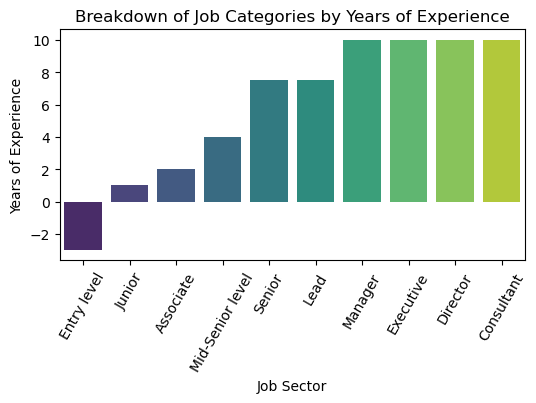

In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# job categories and experience
job_experience = {
    'Entry level': 0-3,
    'Junior': 1,  # Averaging between 0-2 years
    'Associate': 2,  # Averaging between 1-3 years
    'Mid-Senior level': 4,  # Averaging between 3-5 years
    'Senior': 7.5,  # Averaging between 5-10 years
    'Lead': 7.5,  # Averaging between 5-10 years
    'Manager': 10,  # At the start of the 5-10+ range
    'Executive': 10,
    'Director': 10,
    'Consultant': 10,
    'Unknown': float('nan')  # For visualization purposes, use NaN
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(job_experience.items()), columns=['Sector', 'Years of Experience'])

# Exclude 'Unknown' for some visualizations if they include NaN
df_filtered = df.dropna()

# Plotting with Seaborn
plt.figure(figsize=(6, 3))
sns.barplot(x='Sector', y='Years of Experience', data=df_filtered, palette='viridis')

plt.title('Breakdown of Job Categories by Years of Experience')
plt.xlabel('Job Sector')
plt.ylabel('Years of Experience')
plt.xticks(rotation=60)
plt.show()

In [189]:
job_experience

{'Entry level': -3,
 'Junior': 1,
 'Associate': 2,
 'Mid-Senior level': 4,
 'Senior': 7.5,
 'Lead': 7.5,
 'Manager': 10,
 'Executive': 10,
 'Director': 10,
 'Consultant': 10,
 'Unknown': nan}

/var/folders/gq/19wnck6n1lggc_91r4nzbjk80000gn/T/ipykernel_16298/2899959839.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


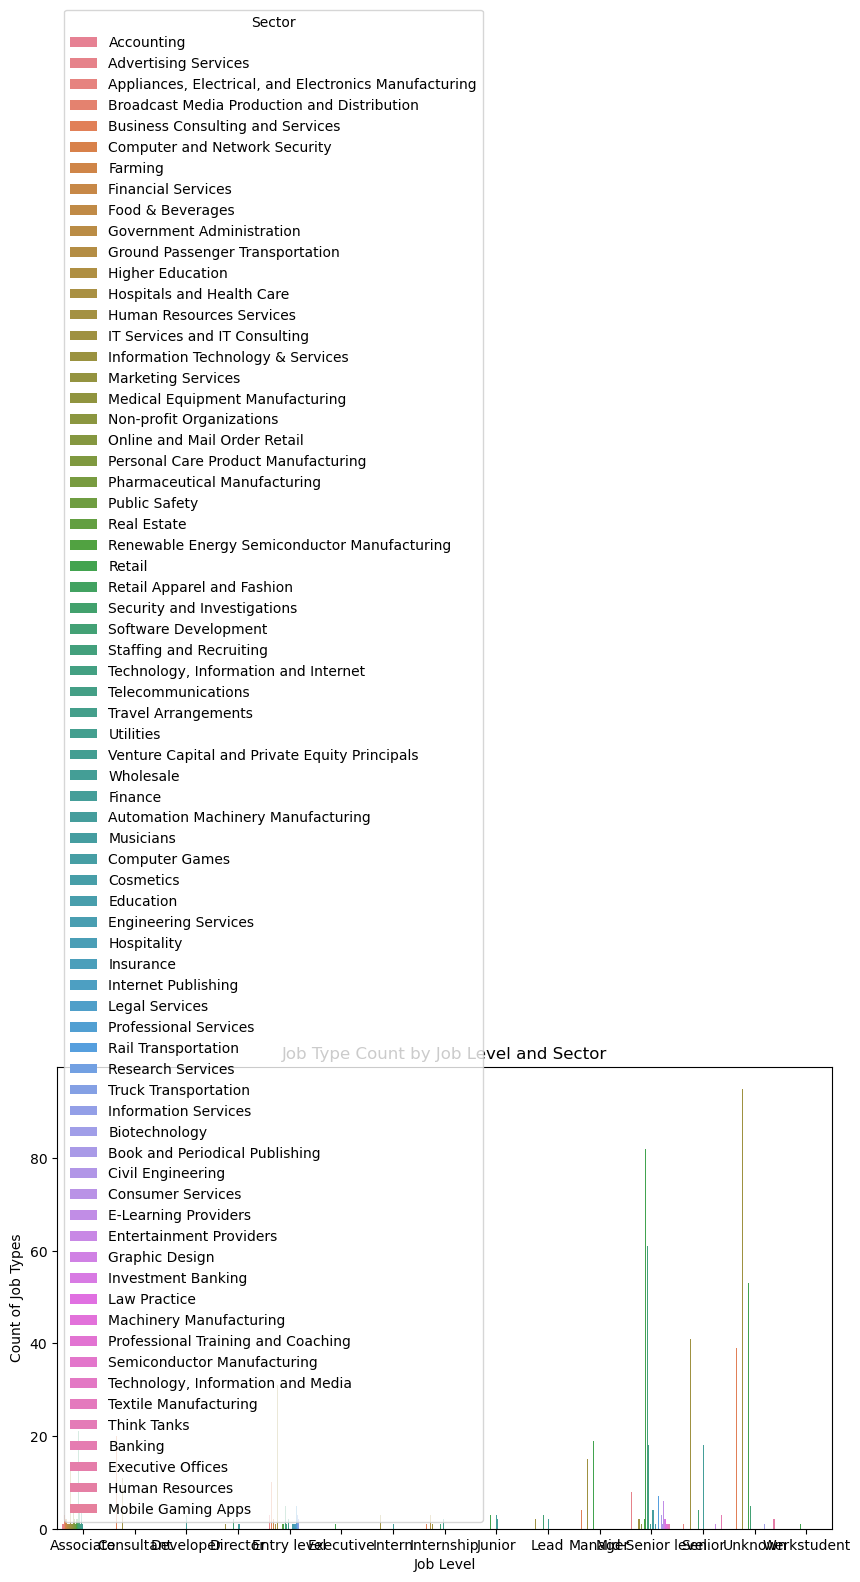

In [191]:

grouped_data = test.groupby(["job_level", "sector"])["job_type"].count().reset_index()

# Rename the count column for clarity
grouped_data = grouped_data.rename(columns={"job_type": "type_count"})

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x="job_level", y="type_count", hue="sector", dodge=True)

# Add titles and labels
plt.title("Job Type Count by Job Level and Sector")
plt.xlabel("Job Level")
plt.ylabel("Count of Job Types")
plt.legend(title="Sector")
plt.tight_layout()

# Display the plot
plt.show()


/var/folders/gq/19wnck6n1lggc_91r4nzbjk80000gn/T/ipykernel_16298/3981806831.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Data Analysts', x='Sector', data=df_sectors, palette='coolwarm')


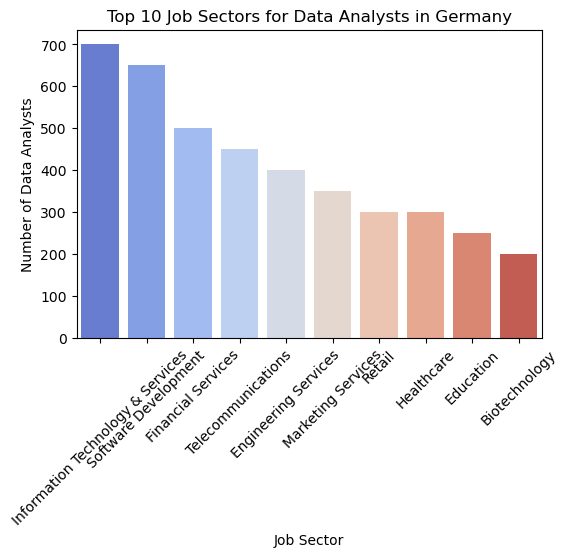

In [197]:
# Define job sectors and hypothetical counts of data analysts
job_sectors = {
    'Information Technology & Services': 700,
    'Financial Services': 500,
    'Engineering Services': 400,
    'Software Development': 650,
    'Retail': 300,
    'Marketing Services': 350,
    'Telecommunications': 450,
    'Biotechnology': 200,
    'Education': 250,
    'Healthcare': 300
}

# Convert to DataFrame
df_sectors = pd.DataFrame(list(job_sectors.items()), columns=['Sector', 'Data Analysts'])

# Sort the DataFrame for a better visualization
df_sectors = df_sectors.sort_values(by='Data Analysts', ascending=False)

# Plot using Seaborn, flipping x and y
plt.figure(figsize=(6, 4))
sns.barplot(y='Data Analysts', x='Sector', data=df_sectors, palette='coolwarm')

plt.title('Top 10 Job Sectors for Data Analysts in Germany')
plt.ylabel('Number of Data Analysts')
plt.xlabel('Job Sector')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()